In [1]:
# Daten extraktion aus https://github.com/Sruthi96200/NASA-Bearing-Dataset/blob/master/DataMining_Code.ipynb
import os
import pandas as pd
import numpy as np

data_dir_train = "IMS/2nd_test/"   #NASA IMS BEARING DATASET 2TER TEST
data_frames = []

for filename in os.listdir(data_dir_train):
    dataset = pd.read_csv(os.path.join(data_dir_train, filename), sep="\t")
    dataset_mean_abs = np.array(dataset.abs().mean())                       # Alle Messdaten einer Textdatei als einzelnen abs.mean abbilden. 984 Dateien -> 984 Datenpunkte für jeweils 4 Bearings.
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))         
    dataset_mean_abs.index = [filename]                                     # Name der Textdatei als Index
    data_frames.append(dataset_mean_abs)


merged_data = pd.concat(data_frames)
merged_data.columns = ["Bearing 1", "Bearing 2", "Bearing 3", "Bearing 4"]



In [2]:
merged_data.index = pd.to_datetime(merged_data.index, format="%Y.%m.%d.%H.%M.%S")

merged_data = merged_data.sort_index()
merged_data.to_csv("merged_Dataset_BearingTest_2.csv")

merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


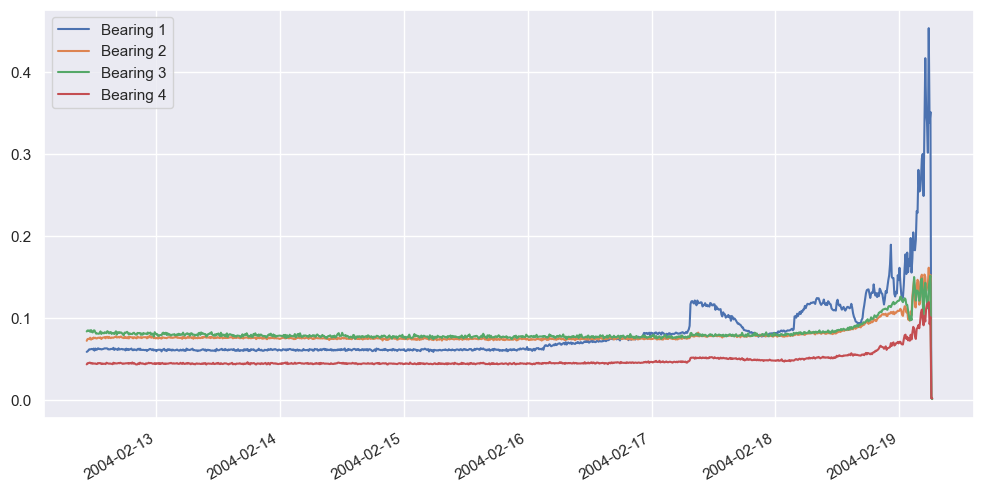

In [ ]:

import seaborn as sns
sns.set_theme(color_codes=True)
import matplotlib.pyplot as plt
merged_data.plot(figsize = (12, 6))
plt.savefig("1.png", dpi=150)

Zu sehen in der Graphik und aus den Angaben zu dem Datenset, fällt Bearing 1 aus in test 2
Ab hier genauere Analyse von Bearing 1

Anzahl Dateien: 984
Samples pro Datei: 20479
Top 5 Frequenzen:
1. Frequency: 985.40 Hz, Amplitude: 428.21
2. Frequency: 49.81 Hz, Amplitude: 121.35
3. Frequency: 64.46 Hz, Amplitude: 90.11
4. Frequency: 978.56 Hz, Amplitude: 77.08
5. Frequency: 992.24 Hz, Amplitude: 74.00


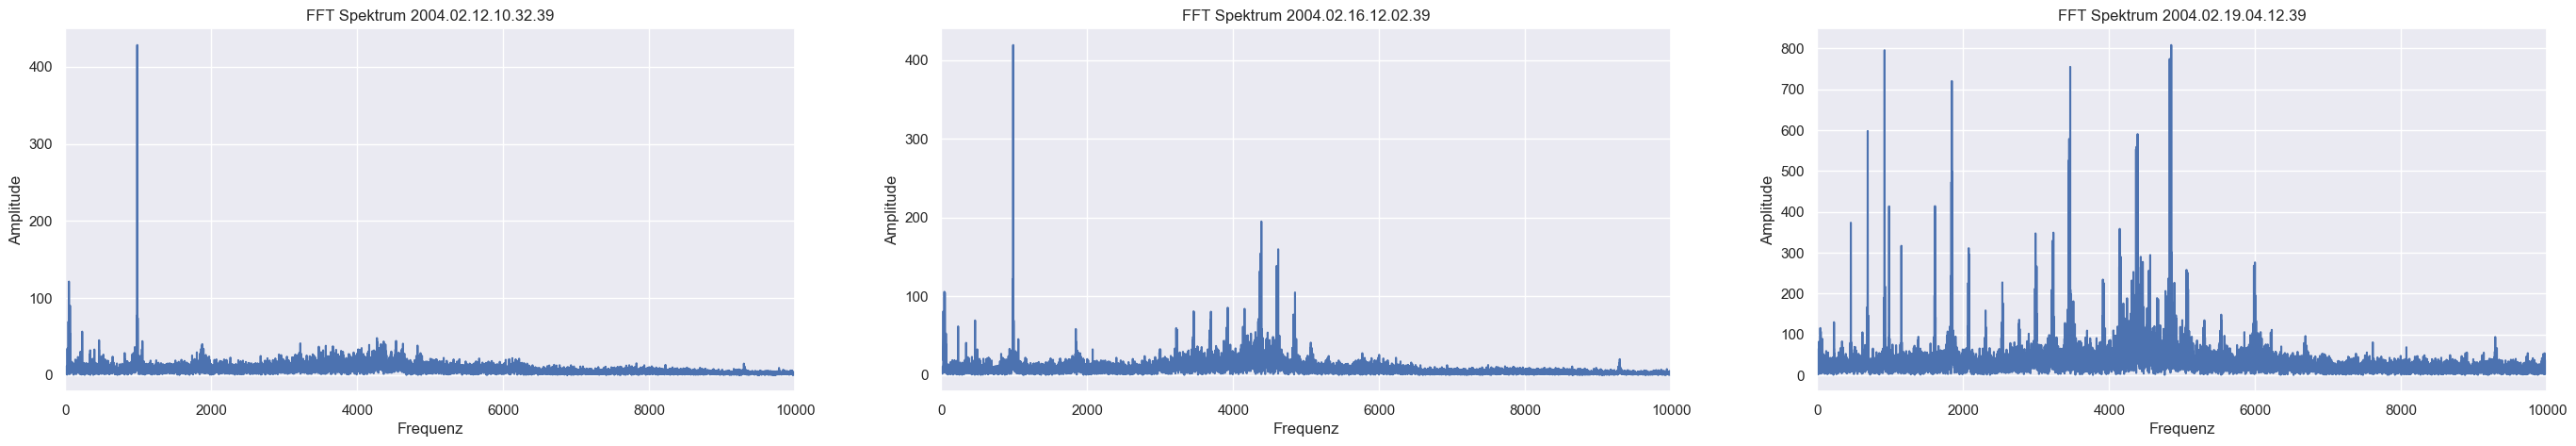

In [ ]:
sampling_rate_hz = 20000  # 20 kHz, Angegeben von NASA für dieses Dataset

all_fft_results = []
file_timestamps = []

for filename in sorted(os.listdir(data_dir_train)):
    dataset = pd.read_csv(os.path.join(data_dir_train, filename), sep="\t")
    bearing1_segment = dataset.iloc[:, 0].values
    
    N = len(bearing1_segment)
    fft_values = np.fft.fft(bearing1_segment)
    fft_freqs = np.fft.fftfreq(N, d=1/sampling_rate_hz)
    
    positive_freqs = fft_freqs[fft_freqs > 0]
    positive_fft = fft_values[fft_freqs > 0]
    amplitude = np.abs(positive_fft)
    
    all_fft_results.append({
        "filename": filename,
        "freqs": positive_freqs,
        "amp": amplitude,
        "N": N
    })
    file_timestamps.append(filename)

print(f"Anzahl Dateien: {len(all_fft_results)}")
print(f"Samples pro Datei: {all_fft_results[0]["N"]}")

ftt_result_0 = all_fft_results[0]
ftt_result_end = all_fft_results[970]
ftt_result_mid = all_fft_results[585]
plt.figure(figsize=(34, 5))

plt.subplot(1,3,1)
plt.plot(ftt_result_0["freqs"], ftt_result_0["amp"])
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.title(f"FFT Spektrum {ftt_result_0["filename"]}")
plt.grid(True)
plt.xlim(0, 10000)

plt.subplot(1,3,2)
plt.plot(ftt_result_mid["freqs"], ftt_result_mid["amp"])
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.title(f"FFT Spektrum {ftt_result_mid["filename"]}")
plt.grid(True)
plt.xlim(0, 10000)

plt.subplot(1,3,3)
plt.plot(ftt_result_end["freqs"], ftt_result_end["amp"])
plt.xlabel("Frequenz")
plt.ylabel("Amplitude")
plt.title(f"FFT Spektrum {ftt_result_end["filename"]}")
plt.grid(True)
plt.xlim(0, 10000)

plt.savefig("FFT_Spektrum.png", dpi=150)

peak_indices = np.argsort(ftt_result_0["amp"])[-5:][::-1]
dominant_freqs = ftt_result_0["freqs"][peak_indices]
dominant_amps = ftt_result_0["amp"][peak_indices]

print("Top 5 Frequenzen:")
for i in range(len(dominant_freqs)):
    freq = dominant_freqs[i]
    amp = dominant_amps[i]
    print(f"{i+1}. Frequency: {freq:.2f} Hz, Amplitude: {amp:.2f}")

Mittelwert: 0.0809
Std: 0.0402
Schwellenwert Degradiert: 0.0930
Schwellenwert Kritisch: 0.1612

Verteilung:
Gesund:     771 Dateien
Degradiert: 184 Dateien
Kritisch:   29 Dateien


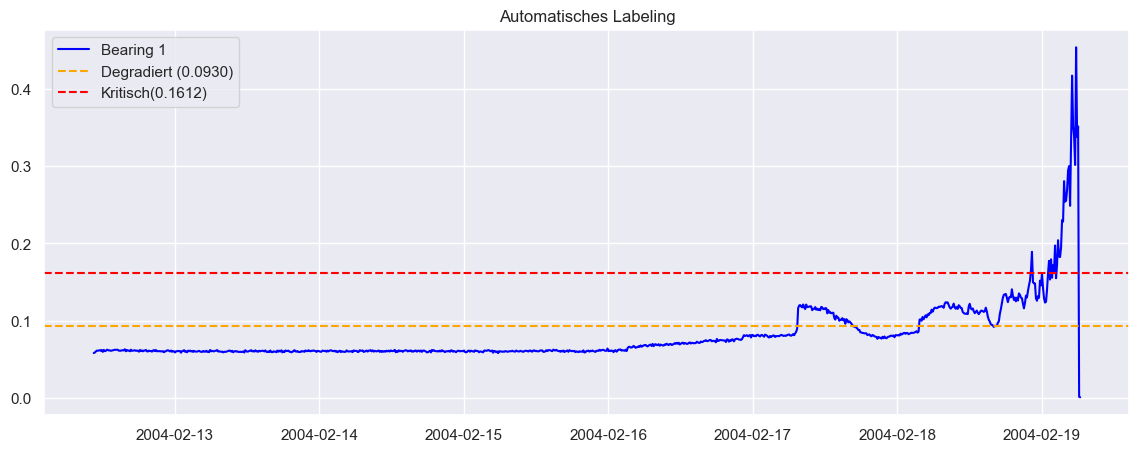

In [ ]:
#LABELING

bearing1_data = merged_data["Bearing 1"]
mean = bearing1_data.mean()
std = bearing1_data.std()

threshold_degraded = mean + 0.3 * std
threshold_critical_high = mean + 2 * std
#threshold_critical_low = mean - 1.8 * std


print(f"Mittelwert: {mean:.4f}")
print(f"Std: {std:.4f}")
print(f"Schwellenwert Degradiert: {threshold_degraded:.4f}")
print(f"Schwellenwert Kritisch: {threshold_critical_high:.4f}")

# Labels vergeben
def assign_label(value):
#    if value < threshold_critical_low:
#        return 2
    if value >= threshold_critical_high:
        return 2 # Kritisch
    elif value >= threshold_degraded:
        return 1  # Degradiert
    else:
        return 0  # Gesund

labels = bearing1_data.apply(assign_label)

print(f"\nVerteilung:")
print(f"Gesund:     {(labels == 0).sum()} Dateien")
print(f"Degradiert: {(labels == 1).sum()} Dateien")
print(f"Kritisch:   {(labels == 2).sum()} Dateien")

plt.figure(figsize=(14, 5))
plt.plot(bearing1_data.index, bearing1_data.values, label="Bearing 1", color="blue")
plt.axhline(y=threshold_degraded, color="orange", linestyle="--", label=f"Degradiert ({threshold_degraded:.4f})")
plt.axhline(y=threshold_critical_high, color="red", linestyle="--", label=f"Kritisch({threshold_critical_high:.4f})")
#plt.axhline(y=threshold_critical_low, color="red", linestyle="--", label=f"Schwelle Kritisch niedrig({threshold_critical_low:.4f})")
plt.legend()
plt.title("Automatisches Labeling")
plt.grid(True)
plt.savefig("labeling.png", dpi=150)
plt.show()

In [6]:
# Feature extract
from scipy.stats import kurtosis

feature_list = []

for fft_result in all_fft_results:
    filename = fft_result["filename"]
    freqs = fft_result["freqs"]
    amp = fft_result["amp"]
    
    raw_data = pd.read_csv(os.path.join(data_dir_train, filename), sep="\t")
    signal = raw_data.iloc[:, 0].values

    rms = np.sqrt(np.mean(signal**2))
    peak = np.max(np.abs(signal))
    peak_to_peak = np.max(signal) - np.min(signal)
    crest_factor = peak / rms if rms != 0 else 0
    kurt = kurtosis(signal)

    dominant_freq = freqs[np.argmax(amp)]
    dominant_amp = np.max(amp)

    features = {
        "filename": filename,
        "rms": rms,
        "peak_to_peak": peak_to_peak,
        "crest_factor": crest_factor,
        "kurtosis": kurt,
        "dominant_freq": dominant_freq,
        "dominant_amp": dominant_amp,
    }
    
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
features_df.set_index("filename", inplace=True)

features_df["label"] = labels.values

print(f"Feature Matrix Shape: {features_df.shape}")
print(f"\nFeatures:")
print(features_df.head())
print(features_df.tail())

Feature Matrix Shape: (984, 7)

Features:
                          rms  peak_to_peak  crest_factor  kurtosis  \
filename                                                              
2004.02.12.10.32.39  0.074180         0.840      6.120246  0.628672   
2004.02.12.10.42.39  0.075382         0.757      5.147132  0.648479   
2004.02.12.10.52.39  0.076228         0.903      6.598658  0.513839   
2004.02.12.11.02.39  0.078726         1.184      7.723037  1.157776   
2004.02.12.11.12.39  0.078475         0.782      4.982488  0.603207   

                     dominant_freq  dominant_amp  label  
filename                                                 
2004.02.12.10.32.39     985.399678    428.208907      0  
2004.02.12.10.42.39     985.399678    377.132610      0  
2004.02.12.10.52.39     985.399678    366.935943      0  
2004.02.12.11.02.39     985.399678    378.080948      0  
2004.02.12.11.12.39     985.399678    352.025011      0  
                          rms  peak_to_peak  crest_fac

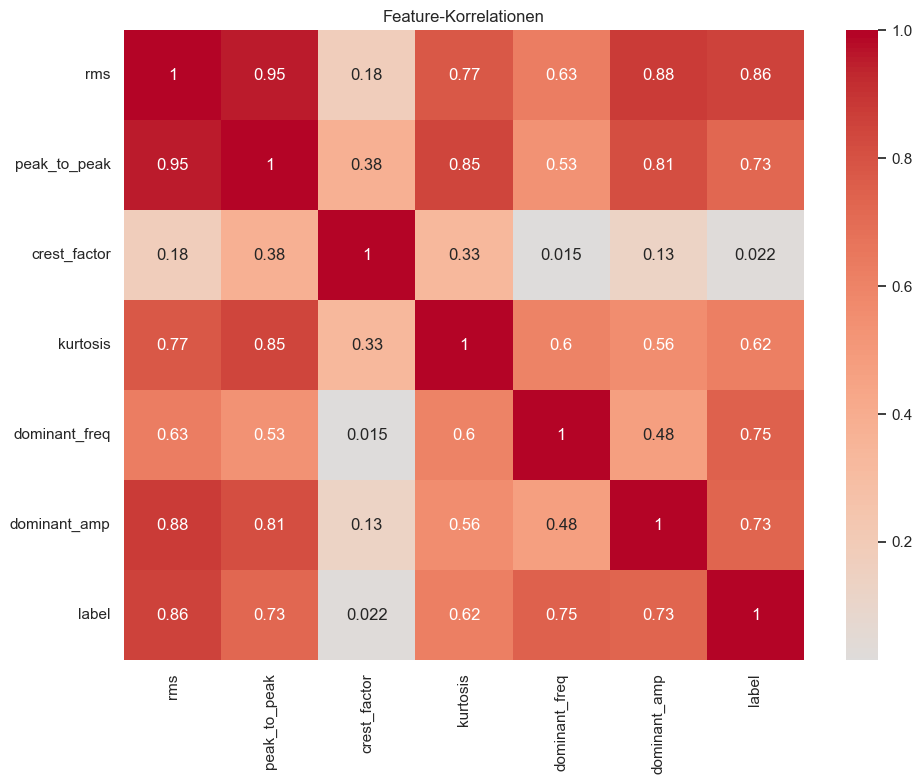

In [7]:
correlation_matrix = features_df[["rms", "peak_to_peak", "crest_factor", 
                                  "kurtosis", "dominant_freq", "dominant_amp", "label"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Feature-Korrelationen")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=150)
plt.show()

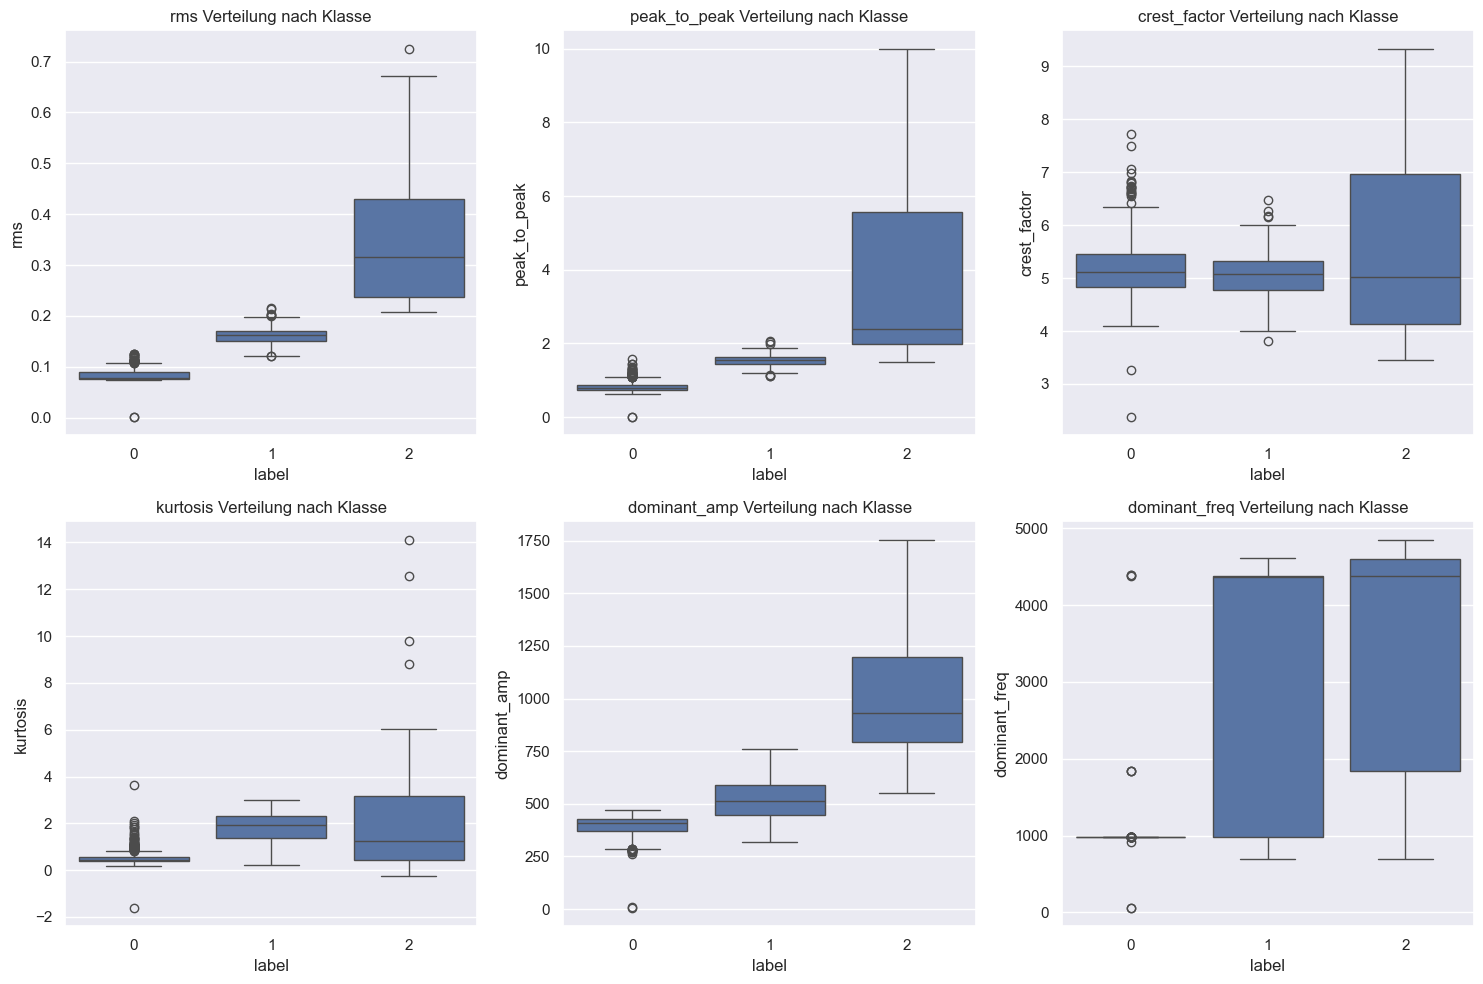

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
features_to_plot = ["rms", "peak_to_peak", "crest_factor", "kurtosis", "dominant_amp", "dominant_freq"]

for idx in range(len(features_to_plot)):
    feature = features_to_plot[idx]
    row = idx // 3
    col = idx % 3
    sns.boxplot(x="label", y=feature, data=features_df, ax=axes[row, col])
    axes[row, col].set_title(f"{feature} Verteilung nach Klasse")

plt.tight_layout()
plt.savefig("feature_distributions.png", dpi=150)
plt.show()